### Based on Parallel Processing in Python, by Jacob Schreiber:

https://homes.cs.washington.edu/~jmschr/lectures/Parallel_Processing_in_Python.html

In [1]:
import pandas as pd
import numpy as numpy
import random as rnd
import matplotlib.pyplot as plt 


In [2]:
def summarize( X ):
    """Summarize the data set by returning the length and the sum."""
    return len(X), sum(X)

In [3]:
X = numpy.random.randn(10000000) + 8.342
x0, x1 = summarize(X)
x1 / x0

8.342038741490098

__%timeit__ will run a piece of code a large number to times and compute an average running time, among other statistics

In [4]:
%timeit summarize(X)

834 ms ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
from multiprocessing import Pool

p = Pool(4)
#note X[i::4] takes every 4th element starting at X[i]
x = p.map( summarize, (X[i::4] for i in range(4)) )
x

[(2500000, 20855489.231848836),
 (2500000, 20851884.02133484),
 (2500000, 20856334.52576243),
 (2500000, 20856679.635957148)]

In [6]:
x0 = sum( y0 for y0, _ in x )
x1 = sum( y1 for _, y1 in x )
x1 / x0

8.342038741490326

In [7]:
n = int(len(X) / 4)
%timeit p.map( summarize, (X[i*n:(i+1)*n] for i in range(4)) )


1.68 s ± 232 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#This line commented out.  Generates error:
#OSError: [Errno 24] Too many open files
#%timeit -n 3 Pool(4)


In [8]:
def scalar_sum(X, y):
    return sum( x*y for x in X )

def pairwise_sum(X):
    return( sum( scalar_sum(X, y) for y in X ) )

In [9]:
X = numpy.random.randn(1000)
%timeit pairwise_sum(X)

194 ms ± 6.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
def scalar_wrapper(args):
    return scalar_sum(*args)

p = Pool(4)
%timeit p.map( scalar_wrapper, ((X, y) for y in X) )

118 ms ± 6.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
from scipy.stats import multivariate_normal

def expectation(X, mus, covs):
    r = numpy.hstack([multivariate_normal.pdf(X, mu, cov)[:, numpy.newaxis] for mu, cov in zip(mus, covs)])
    r = ( r.T / r.T.sum(axis=0) ).T
    return r

def covariance(X, weights):
    n, d = X.shape
    mu = numpy.average(X, axis=0, weights=weights)
    cov = numpy.zeros((d, d))
    
    for i in range(d):
        for j in range(i+1):
            cov[i, j] = weights.dot( (X[:,i] - mu[i])*(X[:,j] - mu[j])  )
            cov[j, i] = cov[i, j]
    
    w_sum = weights.sum()
    return cov / w_sum

def maximization(X, r):
    mus = numpy.array([ numpy.average(X, axis=0, weights=r[:,i]) for i in range(r.shape[1]) ])
    covs = numpy.array([ covariance(X, r[:,i]) for i in range(r.shape[1]) ])
    return mus, covs

In [12]:
def EM(X, mu, cov):
    for i in range(50):
        r = expectation(X, mu, cov)
        mu, cov = maximization(X, r)

    return mu, cov, r

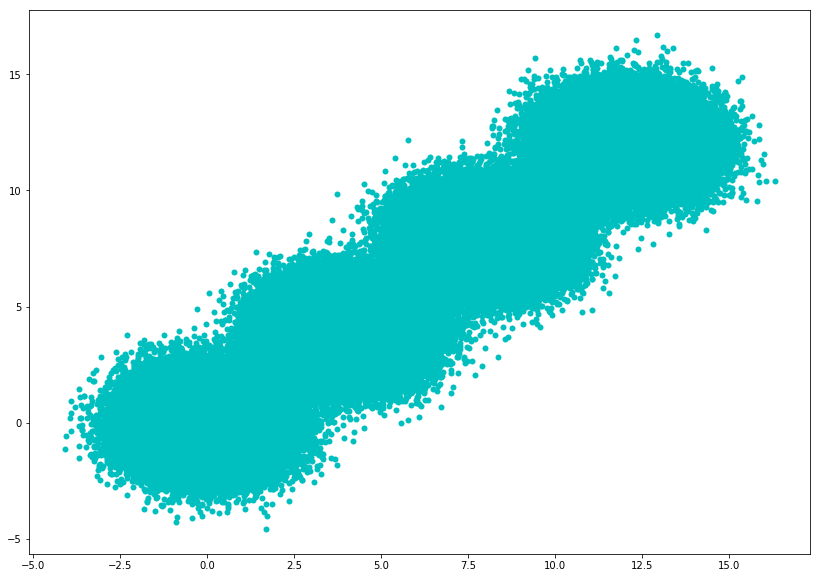

In [13]:
d, m = 2, 4
X = numpy.concatenate([numpy.random.randn(100000, d)+i*4 for i in range(m)])  

plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c='c', linewidth=0 )

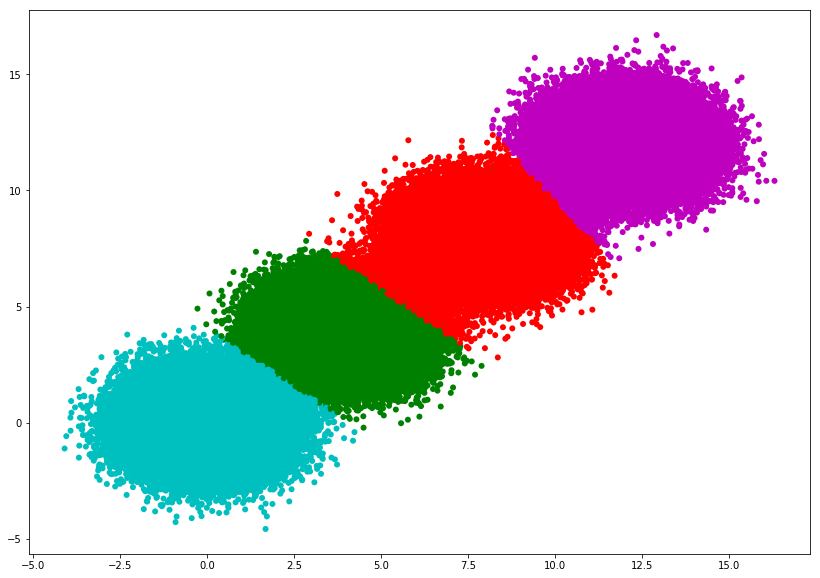

'13.670958757400513'

In [14]:
initial_mu = numpy.random.randn(m, d) + X.mean(axis=0)
initial_cov = numpy.array([numpy.eye(d) for i in range(m)])

mu, cov = initial_mu.copy(), initial_cov.copy()

import time

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
format(toc)

### STOP HERE - the next code segment takes forever.

In [ ]:
from sklearn.externals import joblib
from joblib import Parallel, delayed

def _expectation(X, mu, cov):
    return multivariate_normal.pdf(X, mu, cov)[:, numpy.newaxis]

def _expectation_wrapper(args):
    return _expectation(*args)
 
def expectation(X, mus, covs, parallel):
    tasks = ((X, mu, cov) for mu, cov in zip(mus, covs))
    r = numpy.hstack( parallel( delayed(_expectation_wrapper)(t) for t in tasks ) )
    r = ( r.T / r.T.sum(axis=0) ).T
    return r

def EM(X, mu, cov):
    with Parallel(n_jobs=4) as parallel: 
        for i in range(50):
            r = expectation(X, mu, cov, parallel)
            mu, cov = maximization(X, r)

    return mu, cov, r

mu, cov = initial_mu.copy(), initial_cov.copy()

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
format(toc)